In [220]:
%run __common.py
%load_ext autoreload
%autoreload 2

/iopsstor/scratch/cscs/stefschu/DSM500/github/modulus-a5275d8/modulus/distributed/manager.py:329: UserWarning: Distributed manager is already intialized
  warn("Distributed manager is already intialized")
Provided checkpoint directory /iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/checkpoints does not exist, skipping load


Loaded validation datapipe of size 6
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Is data normalized or standardized?

In [123]:
data = next(iter(trainer.datapipe))

invar = data[0]["invar"]
outvar = data[0]["outvar"]
cos_zenith = data[0]["cos_zenith"]
time_idx = data[0]["time_of_year_idx"].item()

invar_cat = prepare_input(
    invar,
    cos_zenith,
    num_history=cfg.num_history,
    static_data=trainer.static_data,
    step=1,
    time_idx=time_idx,
    stride=cfg.stride,
    dt=cfg.dt,
    num_samples_per_year=cfg.num_samples_per_year_train,
    device=dist.device,
)

invar.shape, invar_cat.shape, outvar.shape, batch.shape

(torch.Size([1, 21, 721, 1440]),
 torch.Size([1, 31, 721, 1440]),
 torch.Size([1, 1, 21, 721, 1440]),
 torch.Size([5, 721, 1440]))

In [124]:
batch = invar_cat[0]
min_values = batch.cpu().numpy().min(axis=(1,2))
max_values = batch.cpu().numpy().max(axis=(1,2))

for i, (min, max) in enumerate(zip(min_values, max_values)):
    print(f"Feature {i}, Min value: {min:.2f}, Max value: {max:.2f}")

Feature 0, Min value: -4.01, Max value: 3.79
Feature 1, Min value: -5.48, Max value: 4.60
Feature 2, Min value: -2.93, Max value: 1.72
Feature 3, Min value: -4.89, Max value: 0.81
Feature 4, Min value: -4.62, Max value: 2.31
Feature 5, Min value: -2.56, Max value: 1.58
Feature 6, Min value: -3.62, Max value: 3.52
Feature 7, Min value: -4.95, Max value: 4.52
Feature 8, Min value: -4.73, Max value: 2.27
Feature 9, Min value: -4.72, Max value: 3.87
Feature 10, Min value: -6.85, Max value: 5.58
Feature 11, Min value: -3.63, Max value: 1.66
Feature 12, Min value: -2.82, Max value: 4.51
Feature 13, Min value: -4.60, Max value: 4.77
Feature 14, Min value: -2.27, Max value: 1.19
Feature 15, Min value: -2.30, Max value: 1.46
Feature 16, Min value: -2.75, Max value: 1.00
Feature 17, Min value: -1.56, Max value: 2.57
Feature 18, Min value: -2.71, Max value: 2.45
Feature 19, Min value: -1.11, Max value: 3.44
Feature 20, Min value: -3.15, Max value: 1.69
Feature 21, Min value: -1.97, Max value: 1.9

In [125]:
mean_values = batch.cpu().numpy().mean(axis=(1,2))
std_values = batch.cpu().numpy().std(axis=(1,2))

for i, (mean, std) in enumerate(zip(mean_values, std_values)):
    print(f"Feature {i}, Mean value: {mean:.2f}, Std value: {std:.2f}")

Feature 0, Mean value: 0.01, Std value: 1.00
Feature 1, Mean value: -0.02, Std value: 1.03
Feature 2, Mean value: -0.04, Std value: 0.99
Feature 3, Mean value: -0.00, Std value: 1.02
Feature 4, Mean value: -0.00, Std value: 0.99
Feature 5, Mean value: -0.08, Std value: 1.01
Feature 6, Mean value: 0.00, Std value: 1.00
Feature 7, Mean value: -0.02, Std value: 1.04
Feature 8, Mean value: -0.01, Std value: 1.02
Feature 9, Mean value: 0.01, Std value: 0.98
Feature 10, Mean value: -0.01, Std value: 1.04
Feature 11, Mean value: -0.04, Std value: 1.02
Feature 12, Mean value: 0.01, Std value: 1.01
Feature 13, Mean value: -0.00, Std value: 1.01
Feature 14, Mean value: -0.07, Std value: 1.02
Feature 15, Mean value: -0.10, Std value: 1.02
Feature 16, Mean value: -0.09, Std value: 0.96
Feature 17, Mean value: 0.03, Std value: 0.99
Feature 18, Mean value: -0.04, Std value: 1.04
Feature 19, Mean value: -0.06, Std value: 0.97
Feature 20, Mean value: -0.03, Std value: 1.00
Feature 21, Mean value: 0.00

## Test fix for cos_zenith (channel 21)

In [94]:
cos_zenith.shape

torch.Size([1, 2, 1, 721, 1440])

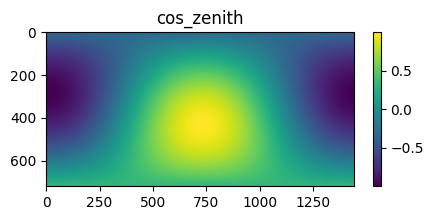

In [95]:
plt.figure(figsize=(5, 2))
plt.imshow(cos_zenith[0, 0, 0].cpu().to(torch.float32).numpy())
plt.colorbar()
plt.title(f"cos_zenith")
plt.show()

In [96]:
temp = torch.squeeze(cos_zenith, dim=2)
temp.shape

torch.Size([1, 2, 721, 1440])

In [97]:
temp_orig = torch.clamp(temp, min=0.0) - 1.0 / np.pi
temp_orig.shape, temp_orig.mean(), temp_orig.std()

(torch.Size([1, 2, 721, 1440]),
 tensor(-0.0945, device='cuda:0'),
 tensor(0.2955, device='cuda:0'))

In [98]:
temp_new = (temp - temp.mean()) / temp.std()
temp_new.shape, temp_new.mean(), temp_new.std()

(torch.Size([1, 2, 721, 1440]),
 tensor(2.8218e-09, device='cuda:0'),
 tensor(1., device='cuda:0'))

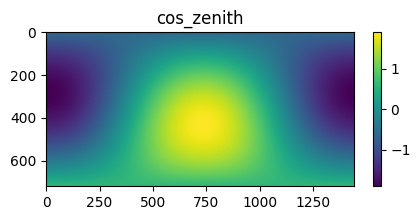

In [99]:
plt.figure(figsize=(5, 2))
plt.imshow(temp_new[0, 0].cpu())
plt.colorbar()
plt.title(f"cos_zenith")
plt.show()

## Investigate static data (channels 22 to 26)

`prepare_input()` just appends what is received from `StaticData()`

In [106]:
trainer.static_data.shape

torch.Size([1, 5, 721, 1440])

Feature 0, Mean value: 0.34, Std value: 0.46
Feature 1, Mean value: 0.00, Std value: 1.00
Feature 2, Mean value: 0.64, Std value: 0.31
Feature 3, Mean value: -0.00, Std value: 0.71
Feature 4, Mean value: -0.00, Std value: 0.71


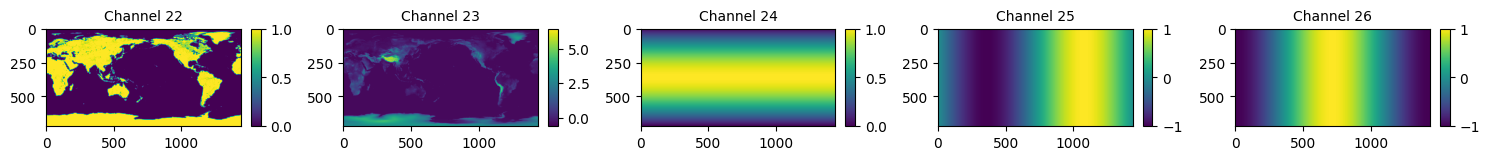

In [120]:
batch = trainer.static_data[0].cpu()
mean_values = batch.cpu().numpy().mean(axis=(1,2))
std_values = batch.cpu().numpy().std(axis=(1,2))

for i, (mean, std) in enumerate(zip(mean_values, std_values)):
    print(f"Feature {i}, Mean value: {mean:.2f}, Std value: {std:.2f}")

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(batch.shape[0]):
    plot(batch[i], f"Channel {22+i}", axs[i])

Feature 0, Mean value: -0.00, Std value: 1.00
Feature 1, Mean value: 0.00, Std value: 1.00
Feature 2, Mean value: -0.00, Std value: 1.00
Feature 3, Mean value: -0.00, Std value: 1.00
Feature 4, Mean value: -0.00, Std value: 1.00


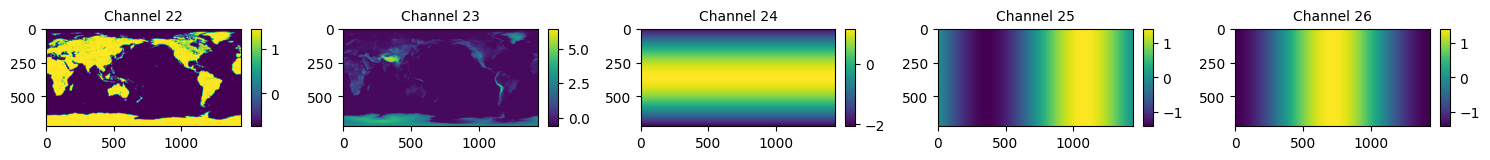

In [121]:
batch[0] = (batch[0] - batch[0].mean()) / batch[0].std()
batch[2] = (batch[2] - batch[2].mean()) / batch[2].std()
batch[3] = (batch[3] - batch[3].mean()) / batch[3].std()
batch[4] = (batch[4] - batch[4].mean()) / batch[4].std()

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(batch.shape[0]):
    plot(batch[i], f"Channel {22+i}", axs[i])

mean_values = batch.cpu().numpy().mean(axis=(1,2))
std_values = batch.cpu().numpy().std(axis=(1,2))

for i, (mean, std) in enumerate(zip(mean_values, std_values)):
    print(f"Feature {i}, Mean value: {mean:.2f}, Std value: {std:.2f}")

## Investigate channels between 27 and 30

In [138]:
def dummy_generate_clock_variables(time_idx):
    num_samples_per_year = cfg.num_samples_per_year_train
    stride = cfg.stride
    dt = cfg.dt 

    # Precompute the tensors to concatenate
    sin_day_of_year = torch.zeros(1, 1, 721, 1440)
    cos_day_of_year = torch.zeros(1, 1, 721, 1440)
    sin_time_of_day = torch.zeros(1, 1, 721, 1440)
    cos_time_of_day = torch.zeros(1, 1, 721, 1440)

    # Calculate the adjusted time index
    adjusted_time_idx = time_idx % num_samples_per_year

    # Compute hour of the year and its decomposition into day of year and time of day
    hour_of_year = adjusted_time_idx * stride * dt
    day_of_year = hour_of_year // 24
    time_of_day = hour_of_year % 24

    # Normalize to the range [0, pi/2]
    normalized_day_of_year = torch.tensor((day_of_year / 365) * (np.pi / 2))
    normalized_time_of_day = torch.tensor((time_of_day / (24 - dt)) * (np.pi / 2))

    # Fill the tensors for the current step
    sin_day_of_year[0, 0] = torch.sin(normalized_day_of_year)
    cos_day_of_year[0, 0] = torch.cos(normalized_day_of_year)
    sin_time_of_day[0, 0] = torch.sin(normalized_time_of_day)
    cos_time_of_day[0, 0] = torch.cos(normalized_time_of_day)

    # Concatenate the new channels to invar
    invar = torch.cat(
        (sin_day_of_year, cos_day_of_year, sin_time_of_day, cos_time_of_day),
        dim=1,
    )

    return invar

dummy_generate_clock_variables(0).shape

torch.Size([1, 4, 721, 1440])

In [ ]:
container = torch.zeros(cfg.num_samples_per_year_train, 4, 721, 1440)

for i in range(cfg.num_samples_per_year_train):
    new_data = dummy_generate_clock_variables(i)[0]

    container[i] = new_data
    if i % 100 == 0:
        print(".", end="")

print()
container.shape

...............


torch.Size([1408, 4, 721, 1440])

tensor(False)
tensor(False)
tensor(False)
tensor(False)


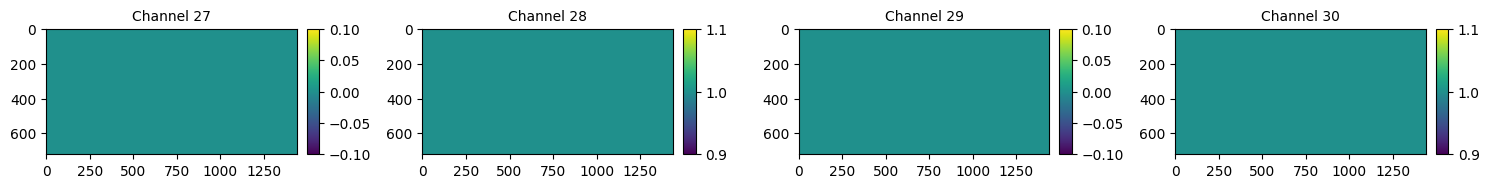

In [151]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    print(torch.any(container[0, i] != container[0, i, 0, 0]))
    plot(container[0, i], f"Channel {27+i}", axs[i])

In [164]:
ts = np.zeros((cfg.num_samples_per_year_train, 4))

for i in range(cfg.num_samples_per_year_train):
    ts[i, 0] = container[i, 0].mean()
    ts[i, 1] = container[i, 1].mean()
    ts[i, 2] = container[i, 2].mean()
    ts[i, 3] = container[i, 3].mean()

ts.shape

(1408, 4)

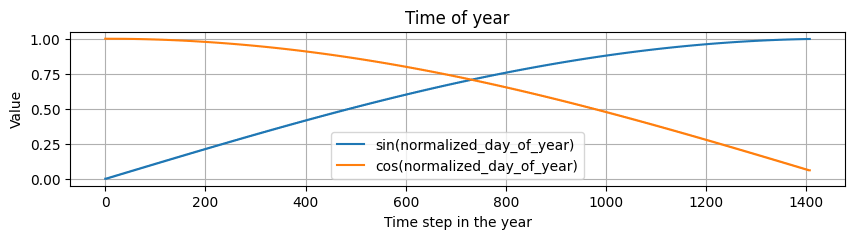

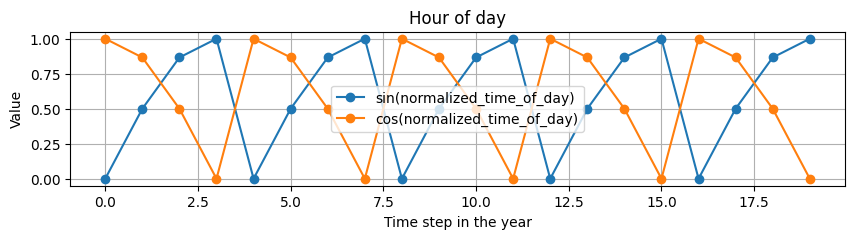

In [177]:
plt.figure(figsize=(10, 2))
plt.plot(list(range(cfg.num_samples_per_year_train)), ts[:, 0], label=f'sin(normalized_day_of_year)')
plt.plot(list(range(cfg.num_samples_per_year_train)), ts[:, 1], label=f'cos(normalized_day_of_year)')
plt.xlabel("Time step in the year")
plt.ylabel("Value")
plt.title("Time of year")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 2))
plt.plot(list(range(20)), ts[:20, 2], marker='o', label=f'sin(normalized_time_of_day)')
plt.plot(list(range(20)), ts[:20, 3], marker='o', label=f'cos(normalized_time_of_day)')

plt.xlabel("Time step in the year")
plt.ylabel("Value")
plt.title("Hour of day")
plt.legend()
plt.grid(True)
plt.show()

<div style="padding: 10px; background-color: #ffcc00; color: black; border-radius: 5px;">
  <strong>Warning:</strong> The hour of day is not smooth. Two adjacent timesteps (e.g. 00:00 and 06:00) appear more distant than others (e.g. 06:00 and 12:00)
</div>

0.0 	 0.0
6.0 	 0.5
12.0 	 1.0
18.0 	 1.5
0.0 	 0.0
6.0 	 0.5
12.0 	 1.0
18.0 	 1.5
0.0 	 0.0
6.0 	 0.5
12.0 	 1.0
18.0 	 1.5
0.0 	 0.0
6.0 	 0.5
12.0 	 1.0
18.0 	 1.5
0.0 	 0.0
6.0 	 0.5
12.0 	 1.0
18.0 	 1.5


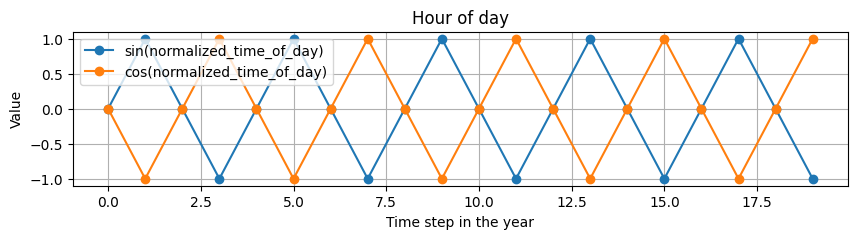

In [195]:
def dummy_generate_clock_variables(time_idx):
    num_samples_per_year = cfg.num_samples_per_year_train
    stride = cfg.stride
    dt = cfg.dt 

    # Precompute the tensors to concatenate
    sin_day_of_year = torch.zeros(1, 1, 721, 1440)
    cos_day_of_year = torch.zeros(1, 1, 721, 1440)
    sin_time_of_day = torch.zeros(1, 1, 721, 1440)
    cos_time_of_day = torch.zeros(1, 1, 721, 1440)

    # Calculate the adjusted time index
    adjusted_time_idx = time_idx % num_samples_per_year

    # Compute hour of the year and its decomposition into day of year and time of day
    hour_of_year = adjusted_time_idx * stride * dt
    time_of_day = hour_of_year % 24


    print(time_of_day, "\t", time_of_day / (12))

    sin_time_of_day[0, 0] = torch.sin(torch.tensor((2 * np.pi * time_of_day) / 24))
    cos_time_of_day[0, 0] = torch.cos(torch.tensor((2 * np.pi * (time_of_day + dt)) / 24))
    invar = torch.cat((sin_day_of_year, cos_day_of_year, sin_time_of_day, cos_time_of_day), dim=1,)
    return invar

time_steps = 20
# Generate data
container = torch.zeros(time_steps, 4, 721, 1440)
for i in range(time_steps):
    new_data = dummy_generate_clock_variables(i)[0]
    container[i] = new_data
# Collect time series
ts = np.zeros((time_steps, 2))
for i in range(time_steps):
    ts[i, 0] = container[i, 2].mean()
    ts[i, 1] = container[i, 3].mean()
# Visualise
plt.figure(figsize=(10, 2))
plt.plot(list(range(time_steps)), ts[:, 0], marker='o', label=f'sin(normalized_time_of_day)')
plt.plot(list(range(time_steps)), ts[:, 1], marker='o', label=f'cos(normalized_time_of_day)')
plt.xlabel("Time step in the year")
plt.ylabel("Value")
plt.title("Hour of day")
plt.legend()
plt.grid(True)
plt.show()


In [206]:
def dummy_generate_clock_variables(time_idx):
    num_samples_per_year = cfg.num_samples_per_year_train
    stride = cfg.stride
    dt = cfg.dt 

    # Precompute the tensors to concatenate
    sin_day_of_year = torch.zeros(1, 1, 721, 1440)
    cos_day_of_year = torch.zeros(1, 1, 721, 1440)
    sin_time_of_day = torch.zeros(1, 1, 721, 1440)
    cos_time_of_day = torch.zeros(1, 1, 721, 1440)

    # Calculate the adjusted time index
    adjusted_time_idx = time_idx % num_samples_per_year

    # Compute hour of the year and its decomposition into day of year and time of day
    hour_of_year = adjusted_time_idx * stride * dt
    day_of_year = hour_of_year // 24
    time_of_day = hour_of_year % 24

    # Normalize to the range [0, pi/2]
    normalized_day_of_year = torch.tensor((day_of_year / 365) * (np.pi / 2))
    
    # Fill the tensors for the current step
    sin_day_of_year[0, 0] = torch.sin(normalized_day_of_year)
    cos_day_of_year[0, 0] = torch.cos(normalized_day_of_year)
    #sin_time_of_day[0, i] = torch.sin(normalized_time_of_day)
    sin_time_of_day[0, 0] = torch.sin(torch.tensor((2 * np.pi * time_of_day) / 24))
    #cos_time_of_day[0, i] = torch.cos(normalized_time_of_day)
    cos_time_of_day[0, 0] = torch.cos(torch.tensor((2 * np.pi * (time_of_day + dt)) / 24))

    # Concatenate the new channels to invar
    invar = torch.cat(
        (sin_day_of_year, cos_day_of_year, sin_time_of_day, cos_time_of_day),
        dim=1,
    )

    return invar


# Generate data
container = torch.zeros(cfg.num_samples_per_year_train, 4, 721, 1440)
for i in range(cfg.num_samples_per_year_train):
    new_data = dummy_generate_clock_variables(i)[0]
    container[i] = new_data
# Collect time series
ts = np.zeros((cfg.num_samples_per_year_train, 4))
for i in range(cfg.num_samples_per_year_train):
    ts[i, 0] = container[i, 0].mean()
    ts[i, 1] = container[i, 1].mean()
    ts[i, 2] = container[i, 2].mean()
    ts[i, 3] = container[i, 3].mean()

ts.shape

(1408, 4)

In [212]:
for m, s in zip(ts.mean(axis=0), ts.std(axis=0)):
    print(m, s)

0.6217995408581125 0.30581369116420254
0.6604384742677212 0.28924783507700846
-2.1855694143368964e-08 0.7071067811865478
-7.946626245924904e-09 0.7071067811865476


## Verify changes

In [223]:
data = next(iter(trainer.datapipe))

invar = data[0]["invar"]
outvar = data[0]["outvar"]
cos_zenith = None # data[0]["cos_zenith"]
time_idx = None # data[0]["time_of_year_idx"].item()

invar_cat = prepare_input(
    invar,
    cos_zenith,
    num_history=cfg.num_history,
    static_data=trainer.static_data,
    step=1,
    time_idx=time_idx,
    stride=cfg.stride,
    dt=cfg.dt,
    num_samples_per_year=cfg.num_samples_per_year_train,
    device=dist.device,
)

invar.shape, invar_cat.shape, outvar.shape, batch.shape

(torch.Size([1, 21, 721, 1440]),
 torch.Size([1, 26, 721, 1440]),
 torch.Size([1, 1, 21, 721, 1440]),
 torch.Size([31, 721, 1440]))

In [224]:
batch = invar_cat[0]
min_values = batch.cpu().numpy().min(axis=(1,2))
max_values = batch.cpu().numpy().max(axis=(1,2))

for i, (min, max) in enumerate(zip(min_values, max_values)):
    print(f"Feature {i}, Min value: {min:.2f}, Max value: {max:.2f}")

Feature 0, Min value: -4.04, Max value: 5.76
Feature 1, Min value: -5.21, Max value: 5.83
Feature 2, Min value: -2.69, Max value: 2.01
Feature 3, Min value: -5.08, Max value: 0.88
Feature 4, Min value: -4.86, Max value: 3.08
Feature 5, Min value: -2.58, Max value: 1.97
Feature 6, Min value: -4.50, Max value: 5.18
Feature 7, Min value: -5.98, Max value: 5.23
Feature 8, Min value: -4.97, Max value: 2.54
Feature 9, Min value: -5.24, Max value: 7.14
Feature 10, Min value: -7.16, Max value: 7.13
Feature 11, Min value: -3.56, Max value: 1.50
Feature 12, Min value: -3.90, Max value: 4.60
Feature 13, Min value: -4.70, Max value: 5.43
Feature 14, Min value: -2.30, Max value: 1.17
Feature 15, Min value: -2.15, Max value: 1.61
Feature 16, Min value: -2.26, Max value: 0.70
Feature 17, Min value: -1.62, Max value: 2.29
Feature 18, Min value: -2.63, Max value: 3.55
Feature 19, Min value: -1.11, Max value: 2.97
Feature 20, Min value: -2.91, Max value: 2.00
Feature 21, Min value: -0.73, Max value: 1.4

In [225]:
batch = invar_cat[0]
mean_values = batch.cpu().numpy().mean(axis=(1,2))
std_values = batch.cpu().numpy().std(axis=(1,2))

for i, (mean, std) in enumerate(zip(mean_values, std_values)):
    print(f"Feature {i}, Mean value: {mean:.2f}, Std value: {std:.2f}")

Feature 0, Mean value: -0.00, Std value: 1.05
Feature 1, Mean value: -0.05, Std value: 1.06
Feature 2, Mean value: -0.09, Std value: 0.94
Feature 3, Mean value: 0.01, Std value: 0.97
Feature 4, Mean value: 0.04, Std value: 1.03
Feature 5, Mean value: -0.09, Std value: 0.93
Feature 6, Mean value: 0.01, Std value: 1.05
Feature 7, Mean value: -0.04, Std value: 1.08
Feature 8, Mean value: 0.04, Std value: 0.99
Feature 9, Mean value: -0.02, Std value: 1.06
Feature 10, Mean value: -0.03, Std value: 1.19
Feature 11, Mean value: -0.04, Std value: 0.93
Feature 12, Mean value: -0.03, Std value: 1.09
Feature 13, Mean value: 0.00, Std value: 1.19
Feature 14, Mean value: -0.05, Std value: 0.93
Feature 15, Mean value: -0.02, Std value: 0.94
Feature 16, Mean value: 0.09, Std value: 0.66
Feature 17, Mean value: 0.00, Std value: 1.01
Feature 18, Mean value: 0.03, Std value: 0.99
Feature 19, Mean value: -0.07, Std value: 0.99
Feature 20, Mean value: -0.07, Std value: 0.93
Feature 21, Mean value: -0.00, 